# Analysis: Visualizing Model Training <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-&amp;-Config" data-toc-modified-id="Imports-&amp;-Config-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports &amp; Config</a></span></li><li><span><a href="#Visualize-Training" data-toc-modified-id="Visualize-Training-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Visualize Training</a></span></li></ul></li><li><span><a href="#GGNN-(A)---Layer-Ablation" data-toc-modified-id="GGNN-(A)---Layer-Ablation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>GGNN (A) - Layer Ablation</a></span></li><li><span><a href="#GGNN-(B)---run_over_binary_choices" data-toc-modified-id="GGNN-(B)---run_over_binary_choices-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>GGNN (B) - run_over_binary_choices</a></span></li><li><span><a href="#GGNN-(C)---run_with_node_types_and_structure_only" data-toc-modified-id="GGNN-(C)---run_with_node_types_and_structure_only-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>GGNN (C) - run_with_node_types_and_structure_only</a></span></li><li><span><a href="#Monitoring-Debug-Trash-Folder" data-toc-modified-id="Monitoring-Debug-Trash-Folder-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Monitoring Debug Trash Folder</a></span></li><li><span><a href="#Transformer-Hyperopt" data-toc-modified-id="Transformer-Hyperopt-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Transformer Hyperopt</a></span></li></ul></div>

## Imports \& Config

In [1]:
# Set editor width to something sane
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook

from pathlib import Path
import sys
# get root repository path
a = !pwd
repo_root = a[0].rsplit('ProGraML', maxsplit=1,)[0] + 'ProGraML'
print(repo_root)
#insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, repo_root)
repo_root = Path(repo_root)

import pandas as pd
from itertools import cycle

import pickle, json
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import torch
from torch_geometric.data import Data, DataLoader

/home/zacharias/ProGraML


## Visualize Training

In [4]:
from deeplearning.ml4pl.poj104.analysis.analysis_helpers import annot_max, make_label, get_all_runs, plot_logs

# GGNN (A) - Layer Ablation

run_over_layer_timesteps
2020-01-23_04:44:49_poj003_24508
2020-01-23_04:42:19_poj002_24507
2020-01-23_05:33:53_poj004_24509
2020-01-23_04:41:44_poj001_24506
2020-01-23_04:40:57_poj000_24505


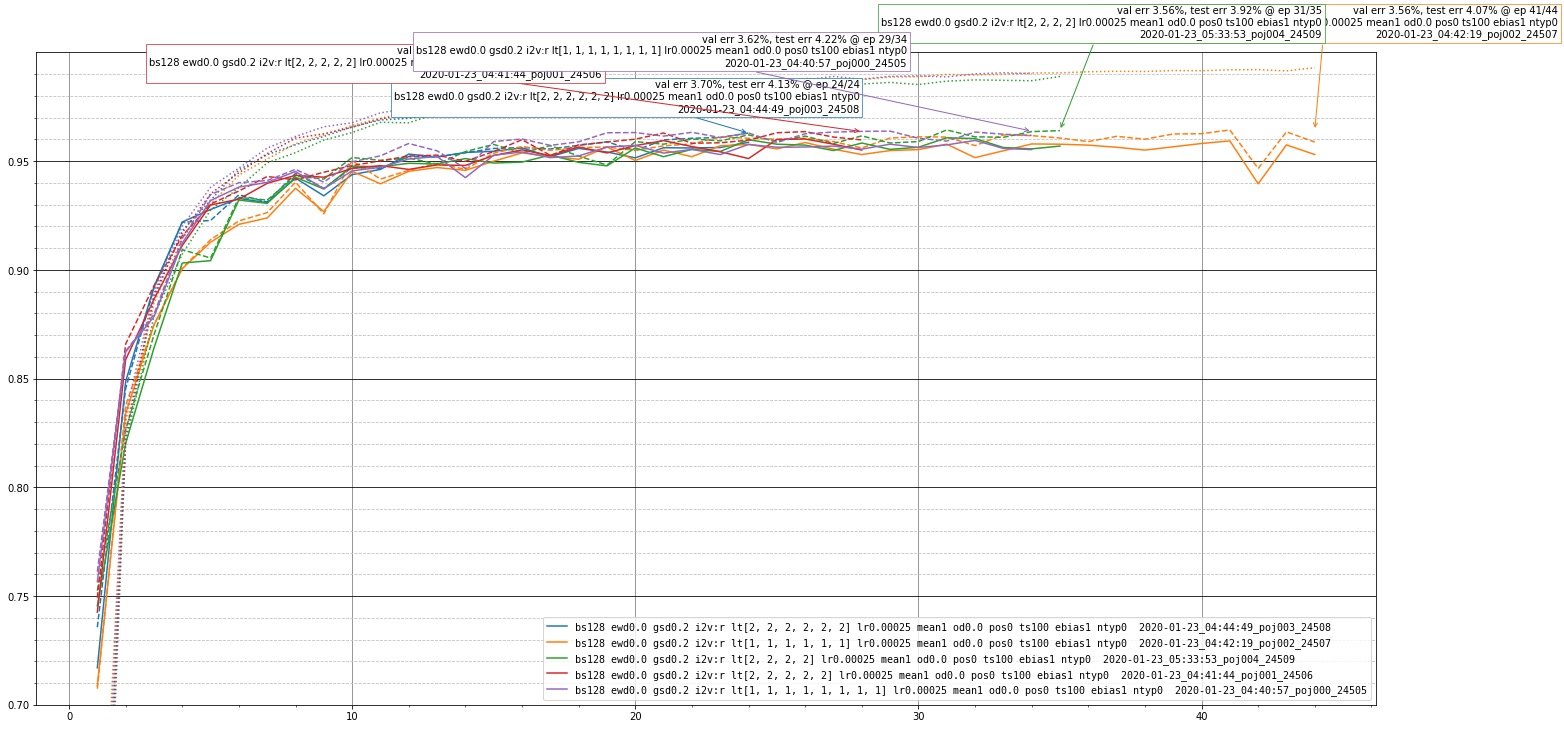

In [62]:
# set log_dir
#sub = 'ault_logs_mirror/example_subfolder'
#sub = 'ault_logs_mirror/sub10_ts4x2_bs64'
#sub = 'ault_logs_mirror/basic_run_full_subset_01-21_weird_testset/'
#sub = 'ault_logs_mirror/large_run_full_subset/'
#sub = 'ault_logs_mirror/run_over_binary_choices/'
sub = 'ault_logs_mirror/run_over_layer_timesteps/'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls -a {log_dir} | grep log
logs, hyps = get_all_runs(log_dir, upper_bound_epochs=60)
plot_logs(logs, hyps, lower_ylim=0.7, display_list=None, legend_loc='lower right')

# GGNN (B) - run_over_binary_choices

run_over_binary_choices
2020-01-23_01:36:53_poj009_24498
2020-01-23_04:38:45_poj013_24502
2020-01-23_01:33:36_poj000_24489
2020-01-23_04:35:01_poj012_24501
2020-01-23_01:35:34_poj001_24490
2020-01-23_01:35:52_poj004_24493
2020-01-23_01:36:53_poj008_24497
2020-01-23_01:35:52_poj005_24494


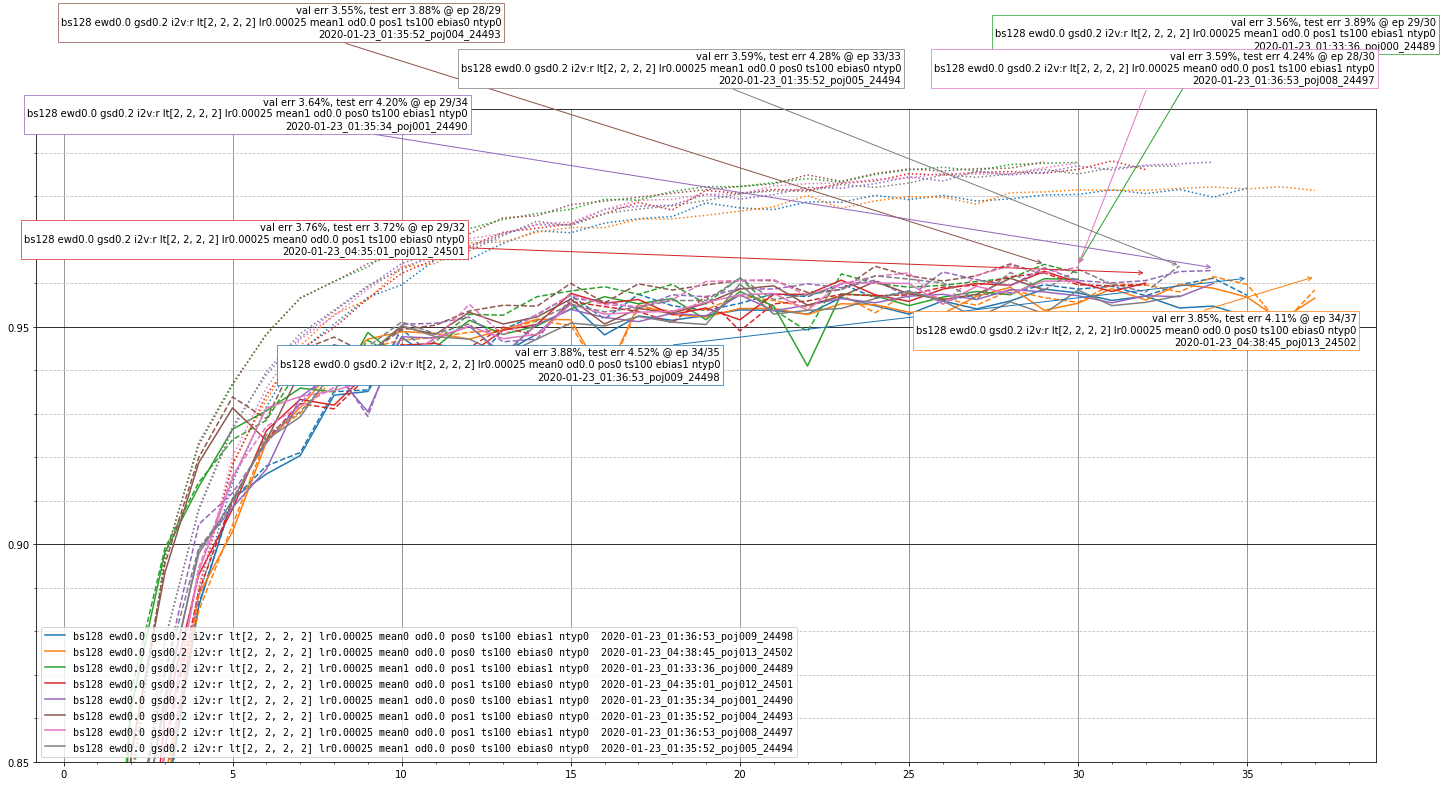

In [59]:
# set log_dir
#sub = 'ault_logs_mirror/example_subfolder'
#sub = 'ault_logs_mirror/sub10_ts4x2_bs64'
#sub = 'ault_logs_mirror/basic_run_full_subset_01-21_weird_testset/'
#sub = 'ault_logs_mirror/large_run_full_subset/'
sub = 'ault_logs_mirror/run_over_binary_choices/'
#sub = 'ault_logs_mirror/run_over_layer_timesteps/'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls -a {log_dir} | grep log
logs, hyps = get_all_runs(log_dir)
plot_logs(logs, hyps)

# GGNN (C) - run_with_node_types_and_structure_only

run_with_node_types_and_structure_only
2020-01-23_23:00:54_nty002_24539
2020-01-23_18:25:55_nty001_24533
2020-01-23_20:56:11_nty000_24530
2020-01-24_01:18:36_nty002_24540
2020-01-23_20:43:33_nty003_24542
2020-01-23_18:24:34_nty000_24529
2020-01-23_20:57:43_nty001_24534
2020-01-23_20:43:30_nty002_24538
2020-01-23_23:28:05_nty000_24531
2020-01-24_01:17:52_nty003_24544
2020-01-23_23:29:51_nty001_24535
2020-01-24_02:00:13_nty000_24532
2020-01-24_02:01:47_nty001_24536
2020-01-23_18:25:59_nty002_24537
2020-01-23_18:25:59_nty003_24541
2020-01-23_23:00:52_nty003_24543


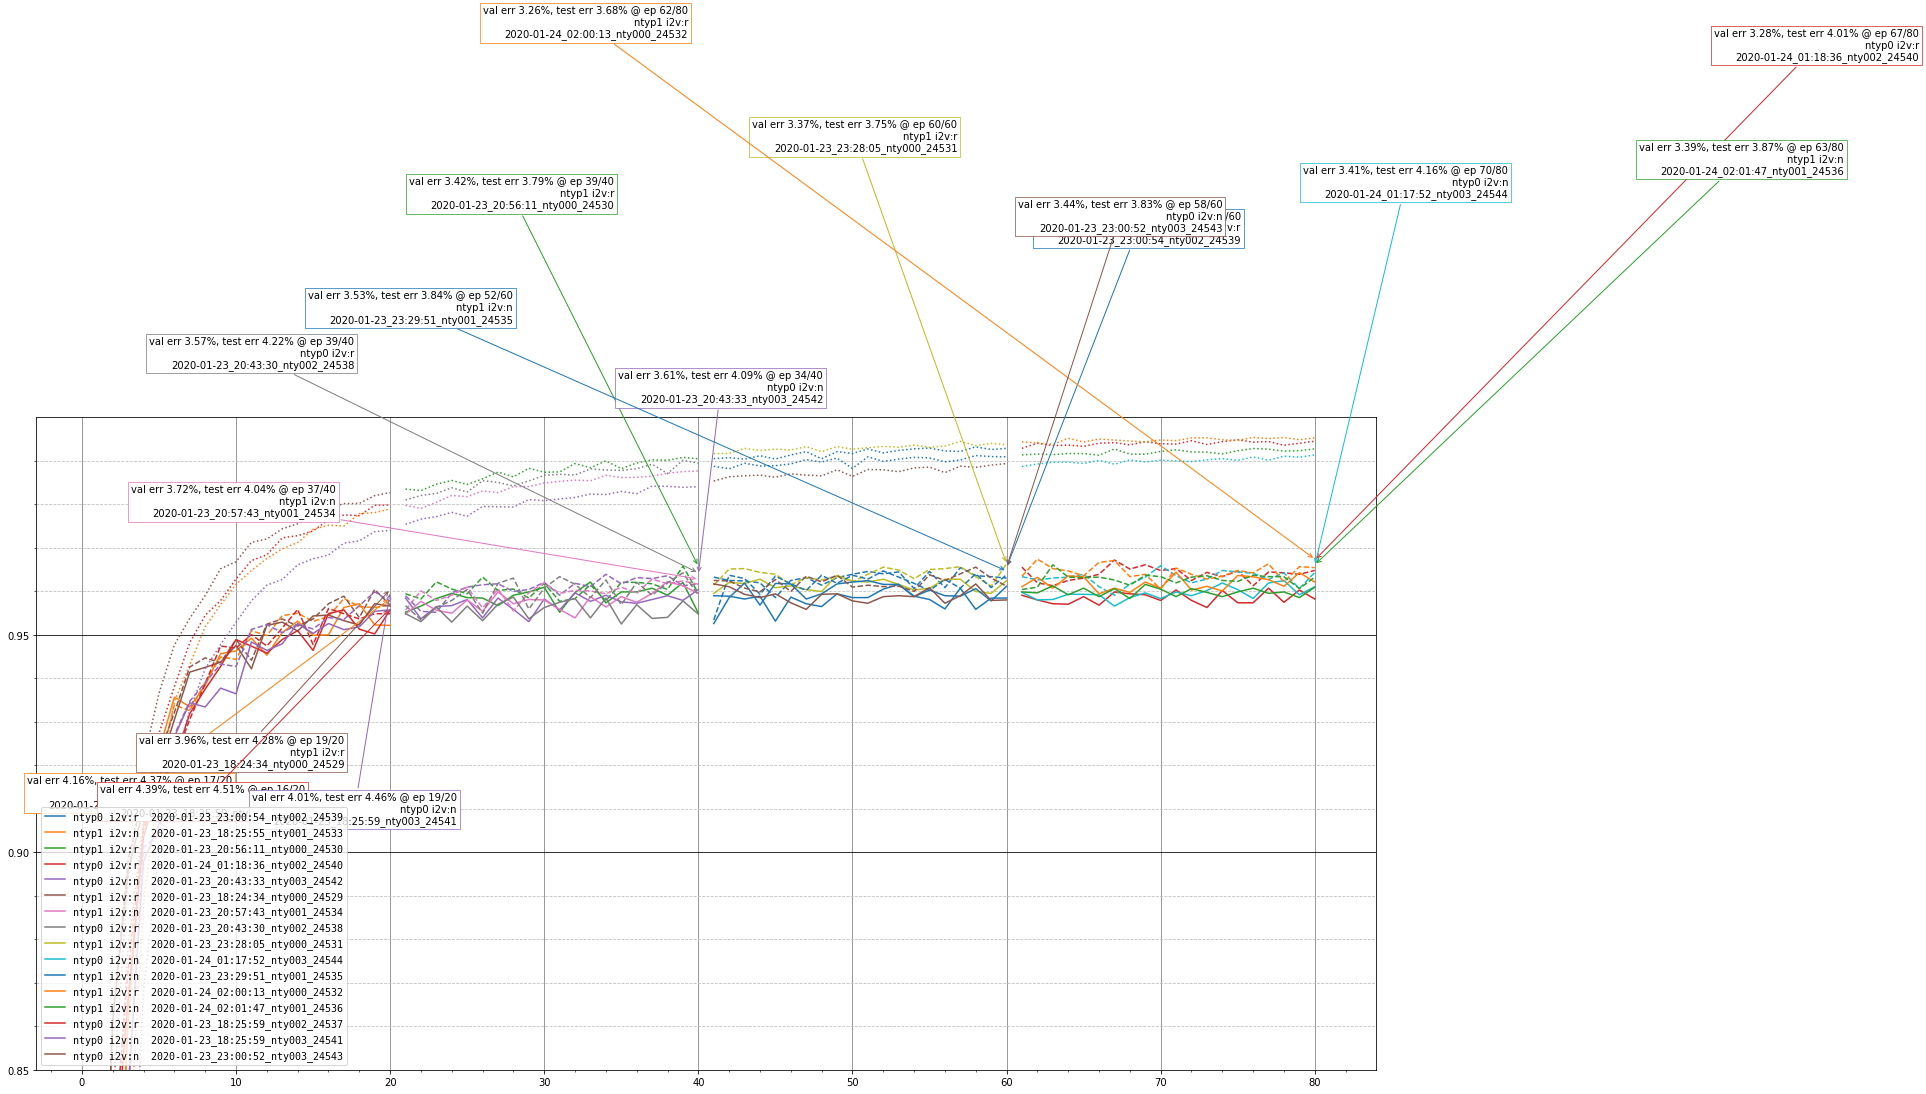

In [60]:
# set log_dir

sub = 'ault_logs_mirror/run_with_node_types_and_structure_only/'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls {log_dir.parent}
logs, hyps = get_all_runs(log_dir)
display_list = ['use_node_types', 'inst2vec_embeddings']
plot_logs(logs, hyps, lower_ylim=0.85, display_list=display_list)

# Monitoring Debug Trash Folder

No handles with labels found to put in legend.


debug_trash_folder


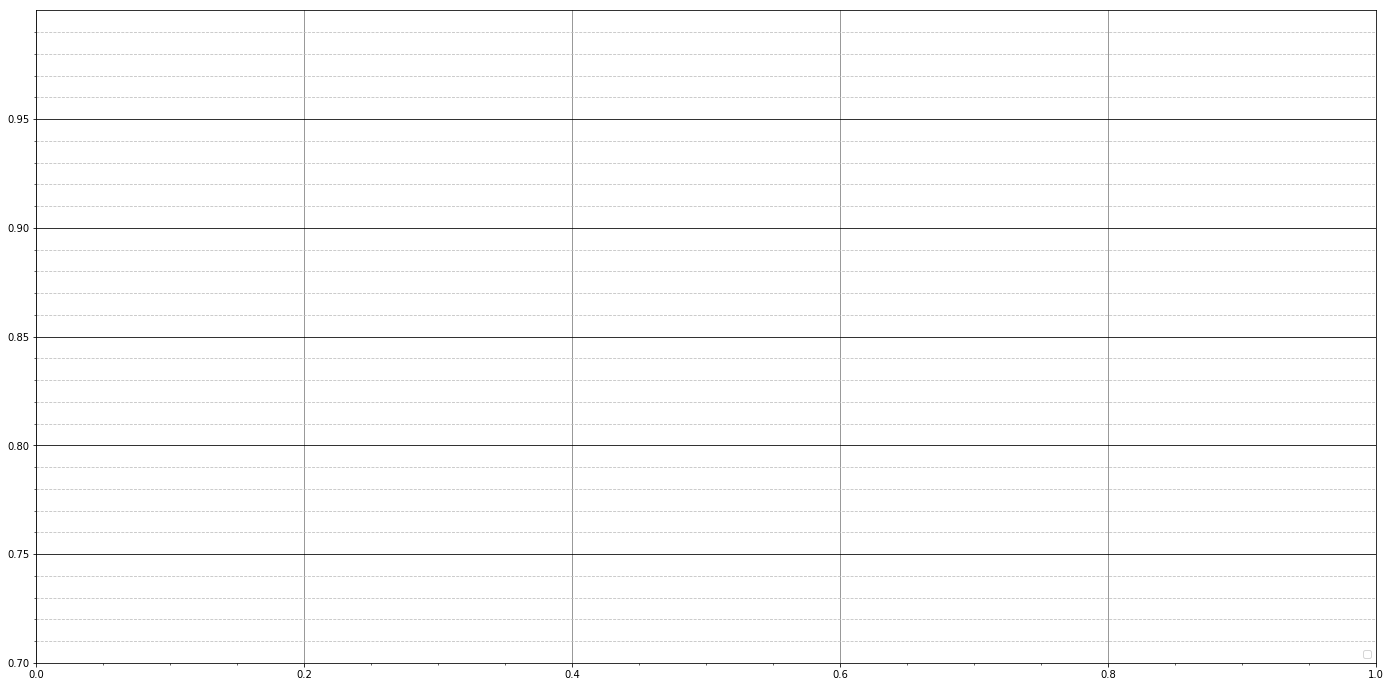

In [73]:
# set log_dir to debug runs 


sub = 'debug_trash_folder'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls {log_dir.parent}
logs, hyps = get_all_runs(log_dir)

display_list = ['train_subset', 'lr', 'tfmr_dropout', 'batch_size', 'layer_timesteps']

plot_logs(logs, hyps, lower_ylim=0.7, display_list=display_list, legend_loc='lower right')

ault_logs_mirror
2020-01-14-01-27-02_70964
2020-01-13-18-27-56_24898
2020-01-16-17-05-32_106751
2020-01-16-18-25-12_165949
2020-01-16-15-13-55_99988
2020-01-13-21-43-44_53349
2020-01-17-12-09-32_123049
2020-01-16-14-09-23_150249
2020-01-16-16-13-57_103581
2020-01-17-12-10-19_123115


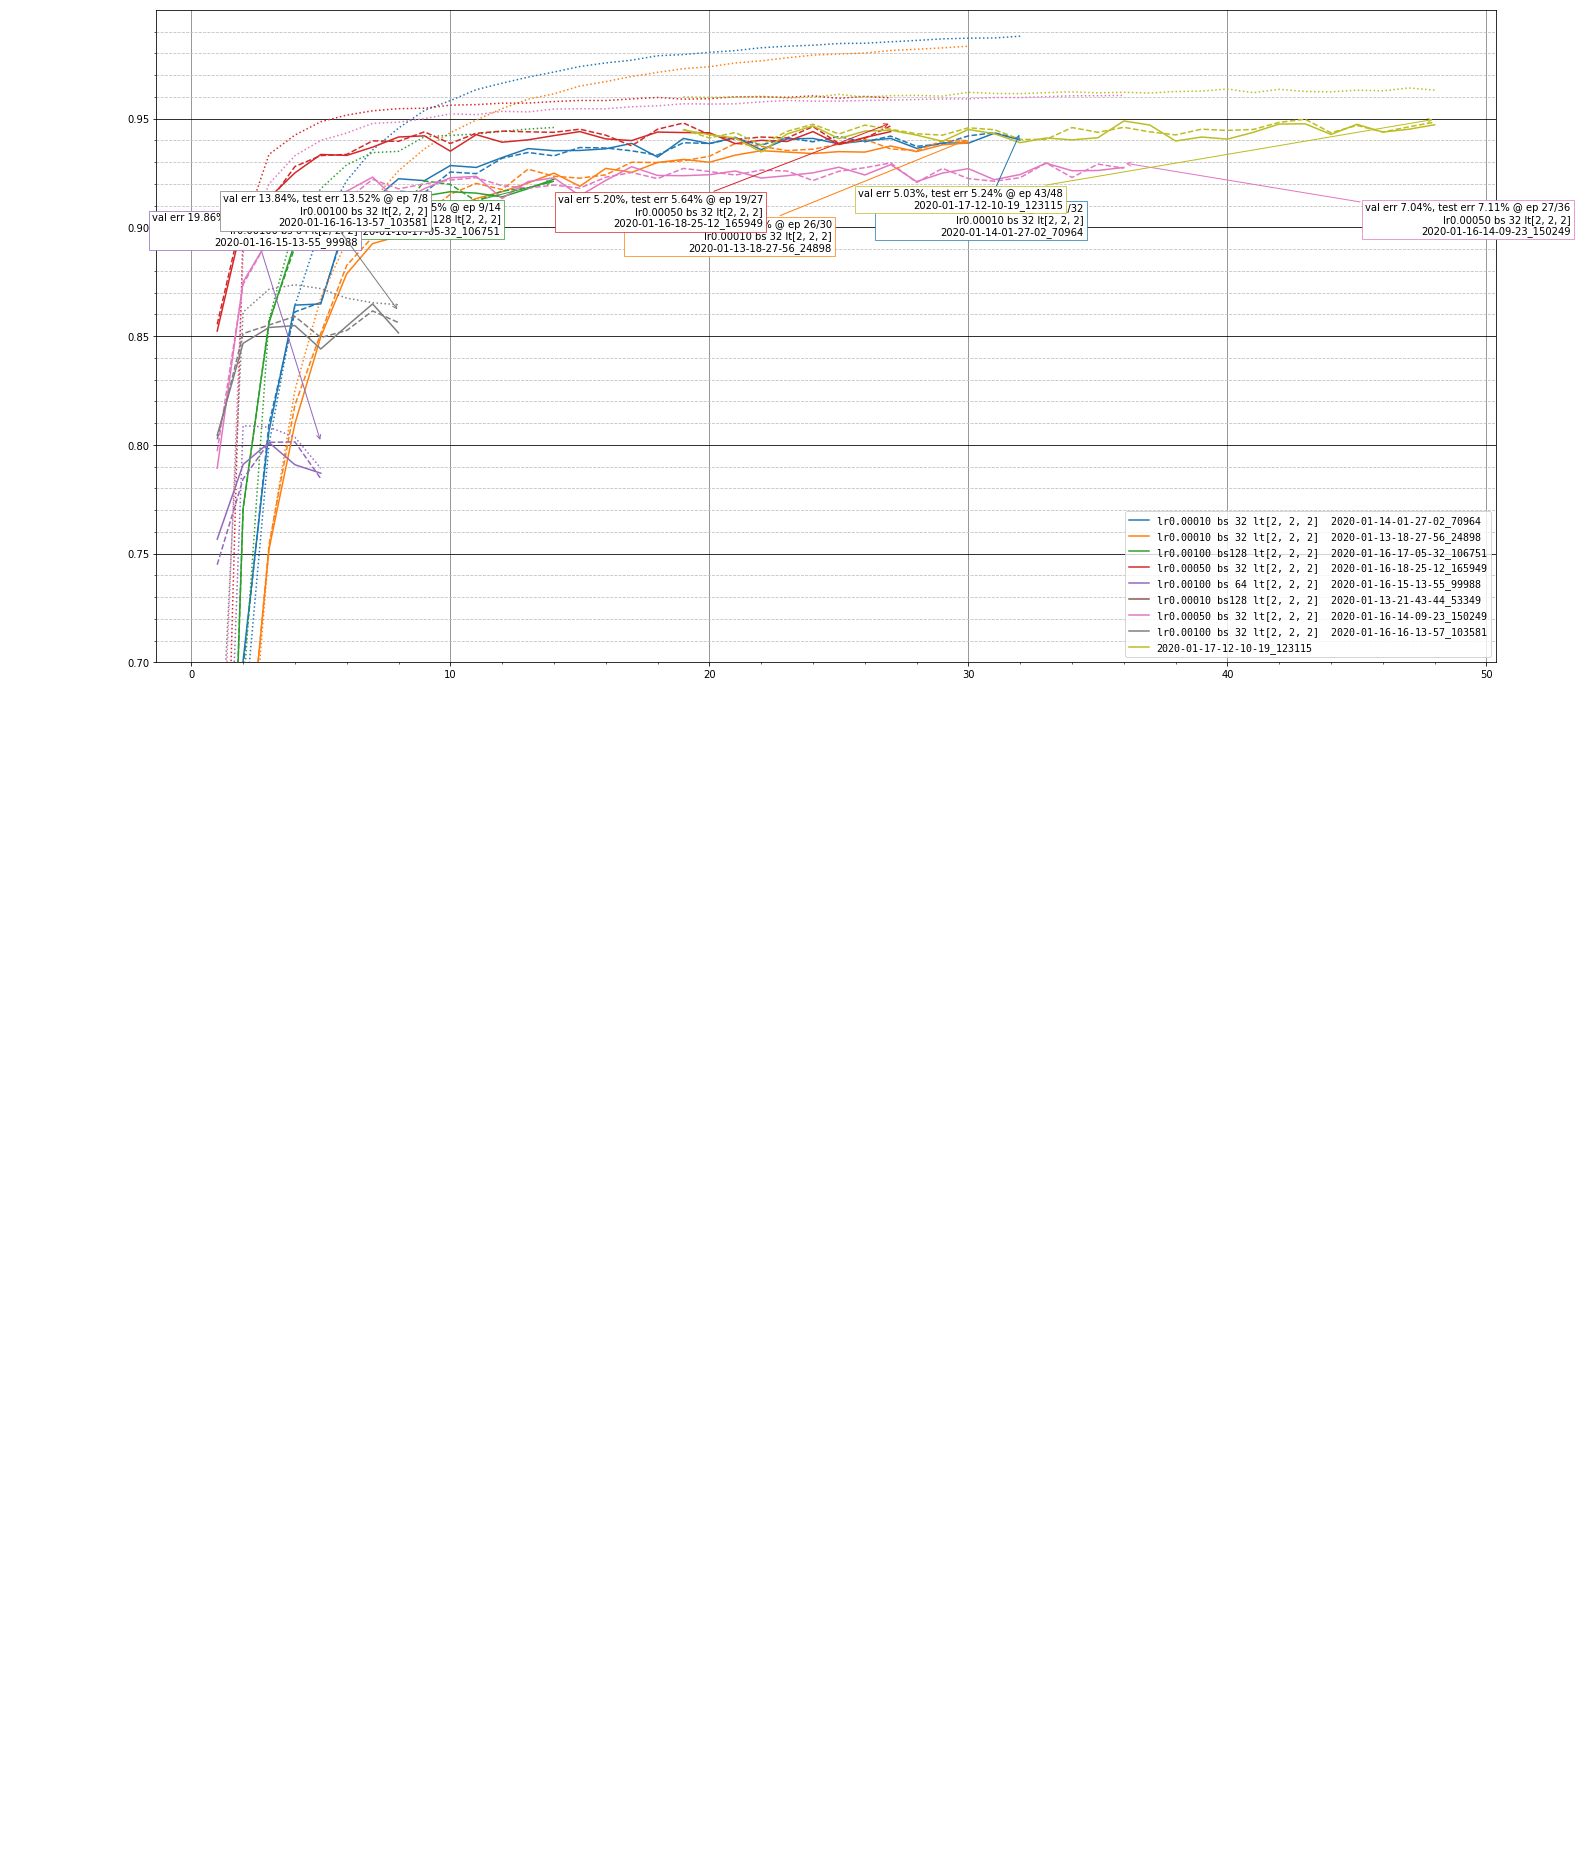

In [97]:
# set log_dir to debug runs 
sub = 'ault_logs_mirror'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls {log_dir.parent}
logs, hyps = get_all_runs(log_dir)

display_list = ['train_subset', 'lr', 'tfmr_dropout', 'batch_size', 'layer_timesteps']

plot_logs(logs, hyps, lower_ylim=0.7, display_list=display_list, legend_loc='lower right')

# Transformer Hyperopt

In [19]:
# set log_dir to debug runs 
sub = 'ault_logs_mirror/poj104/transformer_ablation/'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/logs/' / sub
#!ls {log_dir.parent}
logs, hyps = get_all_runs(log_dir, fuse_by_name=True)



Getting all runs from transformer_ablation
2020-02-12_00:41:56_poj000_29201
2020-02-12_00:45:07_poj001_29206
2020-02-12_00:45:07_poj002_29211
2020-02-12_00:47:23_poj003_29216
2020-02-12_00:47:52_poj004_29221
2020-02-12_00:47:57_poj005_29226
2020-02-12_03:44:33_poj000_29202
fusing 2020-02-12_03:44:33_poj000_29202 with poj000
2020-02-12_03:48:08_poj002_29212
fusing 2020-02-12_03:48:08_poj002_29212 with poj002
2020-02-12_03:50:30_poj001_29207
fusing 2020-02-12_03:50:30_poj001_29207 with poj001
2020-02-12_03:52:58_poj003_29217
fusing 2020-02-12_03:52:58_poj003_29217 with poj003
2020-02-12_03:56:51_poj004_29222
fusing 2020-02-12_03:56:51_poj004_29222 with poj004
2020-02-12_04:04:04_poj005_29227
fusing 2020-02-12_04:04:04_poj005_29227 with poj005
2020-02-12_06:47:32_poj000_29203
fusing 2020-02-12_06:47:32_poj000_29203 with poj000
2020-02-12_06:51:32_poj002_29213
fusing 2020-02-12_06:51:32_poj002_29213 with poj002
2020-02-12_06:55:59_poj001_29208
fusing 2020-02-12_06:55:59_poj001_29208 with p

In [13]:
for file in [log_dir/'2020-02-13_13:44:40_poj010_29414_log.json']:
    with open(file, 'r') as f:

        log = pd.read_json(f, orient='records')

        # handle 'test_only' epochs later!
        if log['epoch'].values[0] == 'test_only':
            continue
    

In [14]:
log

,epoch,test_results,time,train_results,valid_results
0,65,"[0.363848171112762, 0.9608587227583211, 1098.0...",879.870347,"[0.030821971539832002, 0.9877374151332251, 258...","[0.31000544502028604, 0.9627403854490161, 1074..."
1,66,"[0.335830301249945, 0.9578228342188001, 1098.4...",1750.456002,"[0.031969106281838, 0.9875791006845441, 258.98...","[0.39232231324890204, 0.9591346158014311, 1082..."
2,67,"[0.36420572335273105, 0.9595576276699551, 1097...",2620.570045,"[0.029444452712406, 0.9883073471473991, 259.10...","[0.299351603782677, 0.9624125882462181, 1082.3..."
3,68,"[0.38271426792634805, 0.955437493223463, 1097....",3489.187330,"[0.026871126467076, 0.989207477869901, 259.556...","[0.320952631989038, 0.9628496507664661, 1083.3..."
4,69,"[0.36366586644853904, 0.9572807112653151, 1099...",4358.600307,"[0.028247005181301, 0.9890672565010691, 259.33...","[0.35764554676020105, 0.9624125878294031, 1082..."
5,70,"[0.39417105346391, 0.955979616176948, 1099.967...",5228.751081,"[0.026640499234498002, 0.9892934199991851, 259...","[0.375823914926577, 0.9581512237762231, 1075.2..."
6,71,"[0.401519644723129, 0.9591239293071661, 1091.0...",6098.748004,"[0.026783599275040003, 0.9891305822805421, 259...","[0.37847565729952504, 0.9607736013986011, 1083..."
7,72,"[0.375645024999032, 0.9585818063536811, 1099.3...",6968.305282,"[0.02894757907358, 0.9889451282153221, 259.290...","[0.316067053929909, 0.9606643364979671, 1072.7..."
8,73,"[0.372472098705296, 0.9594492030792581, 1100.3...",7838.739273,"[0.026633330926430002, 0.9895648161980031, 259...","[0.333959227960257, 0.9602272735609041, 1074.0..."
9,74,"[0.353509643580512, 0.9555459178141601, 1098.6...",8708.539041,"[0.028415471823561002, 0.988768720683556, 259....","[0.31403095830049504, 0.958041958458773, 1082...."


In [16]:
logs['poj000']

,epoch,time,train_loss,train_acc,train_speed,train_ppl,train_art,train_ort,valid_loss,valid_acc,valid_speed,valid_ppl,valid_art,valid_ort,test_loss,test_acc,test_speed,test_ppl
0,1,682.303866,4.900155,0.482529,330.427348,134.310663,0,0,1.511162,0.721591,1377.291471,4.531994,0,0,1.374352,0.723192,1400.159495,3.952514
1,2,1365.261699,0.659745,0.821390,330.182678,1.934298,0,0,0.980945,0.831622,1378.683221,2.666974,0,0,0.891624,0.839423,1381.421822,2.439088
2,3,2047.367849,0.348840,0.898982,330.560372,1.417423,0,0,0.571264,0.902972,1379.188280,1.770503,0,0,0.536882,0.898515,1400.485484,1.710664
3,4,2730.900850,0.231536,0.929681,329.946254,1.260535,0,0,0.505550,0.908108,1377.587937,1.657897,0,0,0.509006,0.906104,1381.687225,1.663637
4,5,3414.331094,0.174572,0.944346,329.949132,1.190737,0,0,0.453866,0.940013,1379.229063,1.574386,0,0,0.409896,0.935596,1382.177988,1.506662
5,6,4096.638362,0.144246,0.953415,330.499827,1.155168,0,0,0.426393,0.934222,1379.787836,1.531722,0,0,0.412996,0.934728,1382.813767,1.511339
6,7,4779.617379,0.119573,0.960159,330.130738,1.127016,0,0,0.418707,0.932365,1379.539651,1.519995,0,0,0.403338,0.930934,1383.060321,1.496812
7,8,5463.003159,0.098648,0.965772,329.894208,1.103678,0,0,0.258458,0.948864,1378.750864,1.294932,0,0,0.312215,0.948498,1399.548834,1.366448
8,9,6145.809052,0.084767,0.970024,330.214381,1.088463,0,0,0.304171,0.949847,1379.623692,1.355501,0,0,0.276685,0.950775,1400.632282,1.318751
9,10,6828.092356,0.080270,0.971540,330.513977,1.083580,0,0,0.319520,0.954436,1378.338868,1.376466,0,0,0.325953,0.950992,1383.679194,1.385350


In [27]:
pd.set_option('display.max_rows', 500)

In [28]:
logs['poj009']

,epoch,time,train_loss,train_acc,train_speed,train_ppl,train_art,train_ort,valid_loss,valid_acc,valid_speed,valid_ppl,valid_art,valid_ort,test_loss,test_acc,test_speed,test_ppl
0,1,854.862712,4.108600,0.567005,263.690130,60.861450,0,0,1.051172,0.795017,1101.234458,2.861001,0,0,1.066146,0.792150,1132.276399,2.904165
1,2,1709.003907,0.477304,0.867301,263.920504,1.611723,0,0,0.713307,0.860468,1113.198466,2.040730,0,0,0.677523,0.862409,1130.784644,1.968995
2,3,2564.112351,0.264973,0.920838,263.614777,1.303395,0,0,0.401967,0.926246,1113.338978,1.494761,0,0,0.403491,0.922368,1131.202836,1.497042
3,4,3418.759990,0.186140,0.940908,263.762910,1.204590,0,0,0.273475,0.938156,1113.322801,1.314525,0,0,0.336299,0.932994,1131.191325,1.399758
4,5,4274.122381,0.144231,0.952840,263.563522,1.155151,0,0,0.273401,0.939795,1113.187716,1.314427,0,0,0.325957,0.935921,1119.146026,1.385356
5,6,5129.499261,0.120240,0.958816,263.533034,1.127768,0,0,0.277471,0.945149,1113.212832,1.319787,0,0,0.309683,0.940692,1130.814460,1.362992
6,7,5985.027407,0.100761,0.964506,263.488040,1.106012,0,0,0.246034,0.952360,1112.517945,1.278943,0,0,0.318596,0.950233,1131.197610,1.375196
7,8,6840.472354,0.097255,0.966008,263.511465,1.102141,0,0,0.195470,0.954327,1113.329743,1.215883,0,0,0.217837,0.952293,1131.205582,1.243385
8,9,7696.280302,0.084141,0.969662,263.397201,1.087782,0,0,0.242495,0.951267,1113.258354,1.274425,0,0,0.280303,0.948824,1130.598051,1.323531
9,10,8551.900836,0.078475,0.971408,263.453243,1.081636,0,0,0.255281,0.954327,1113.514991,1.290824,0,0,0.328221,0.951101,1119.784515,1.388495


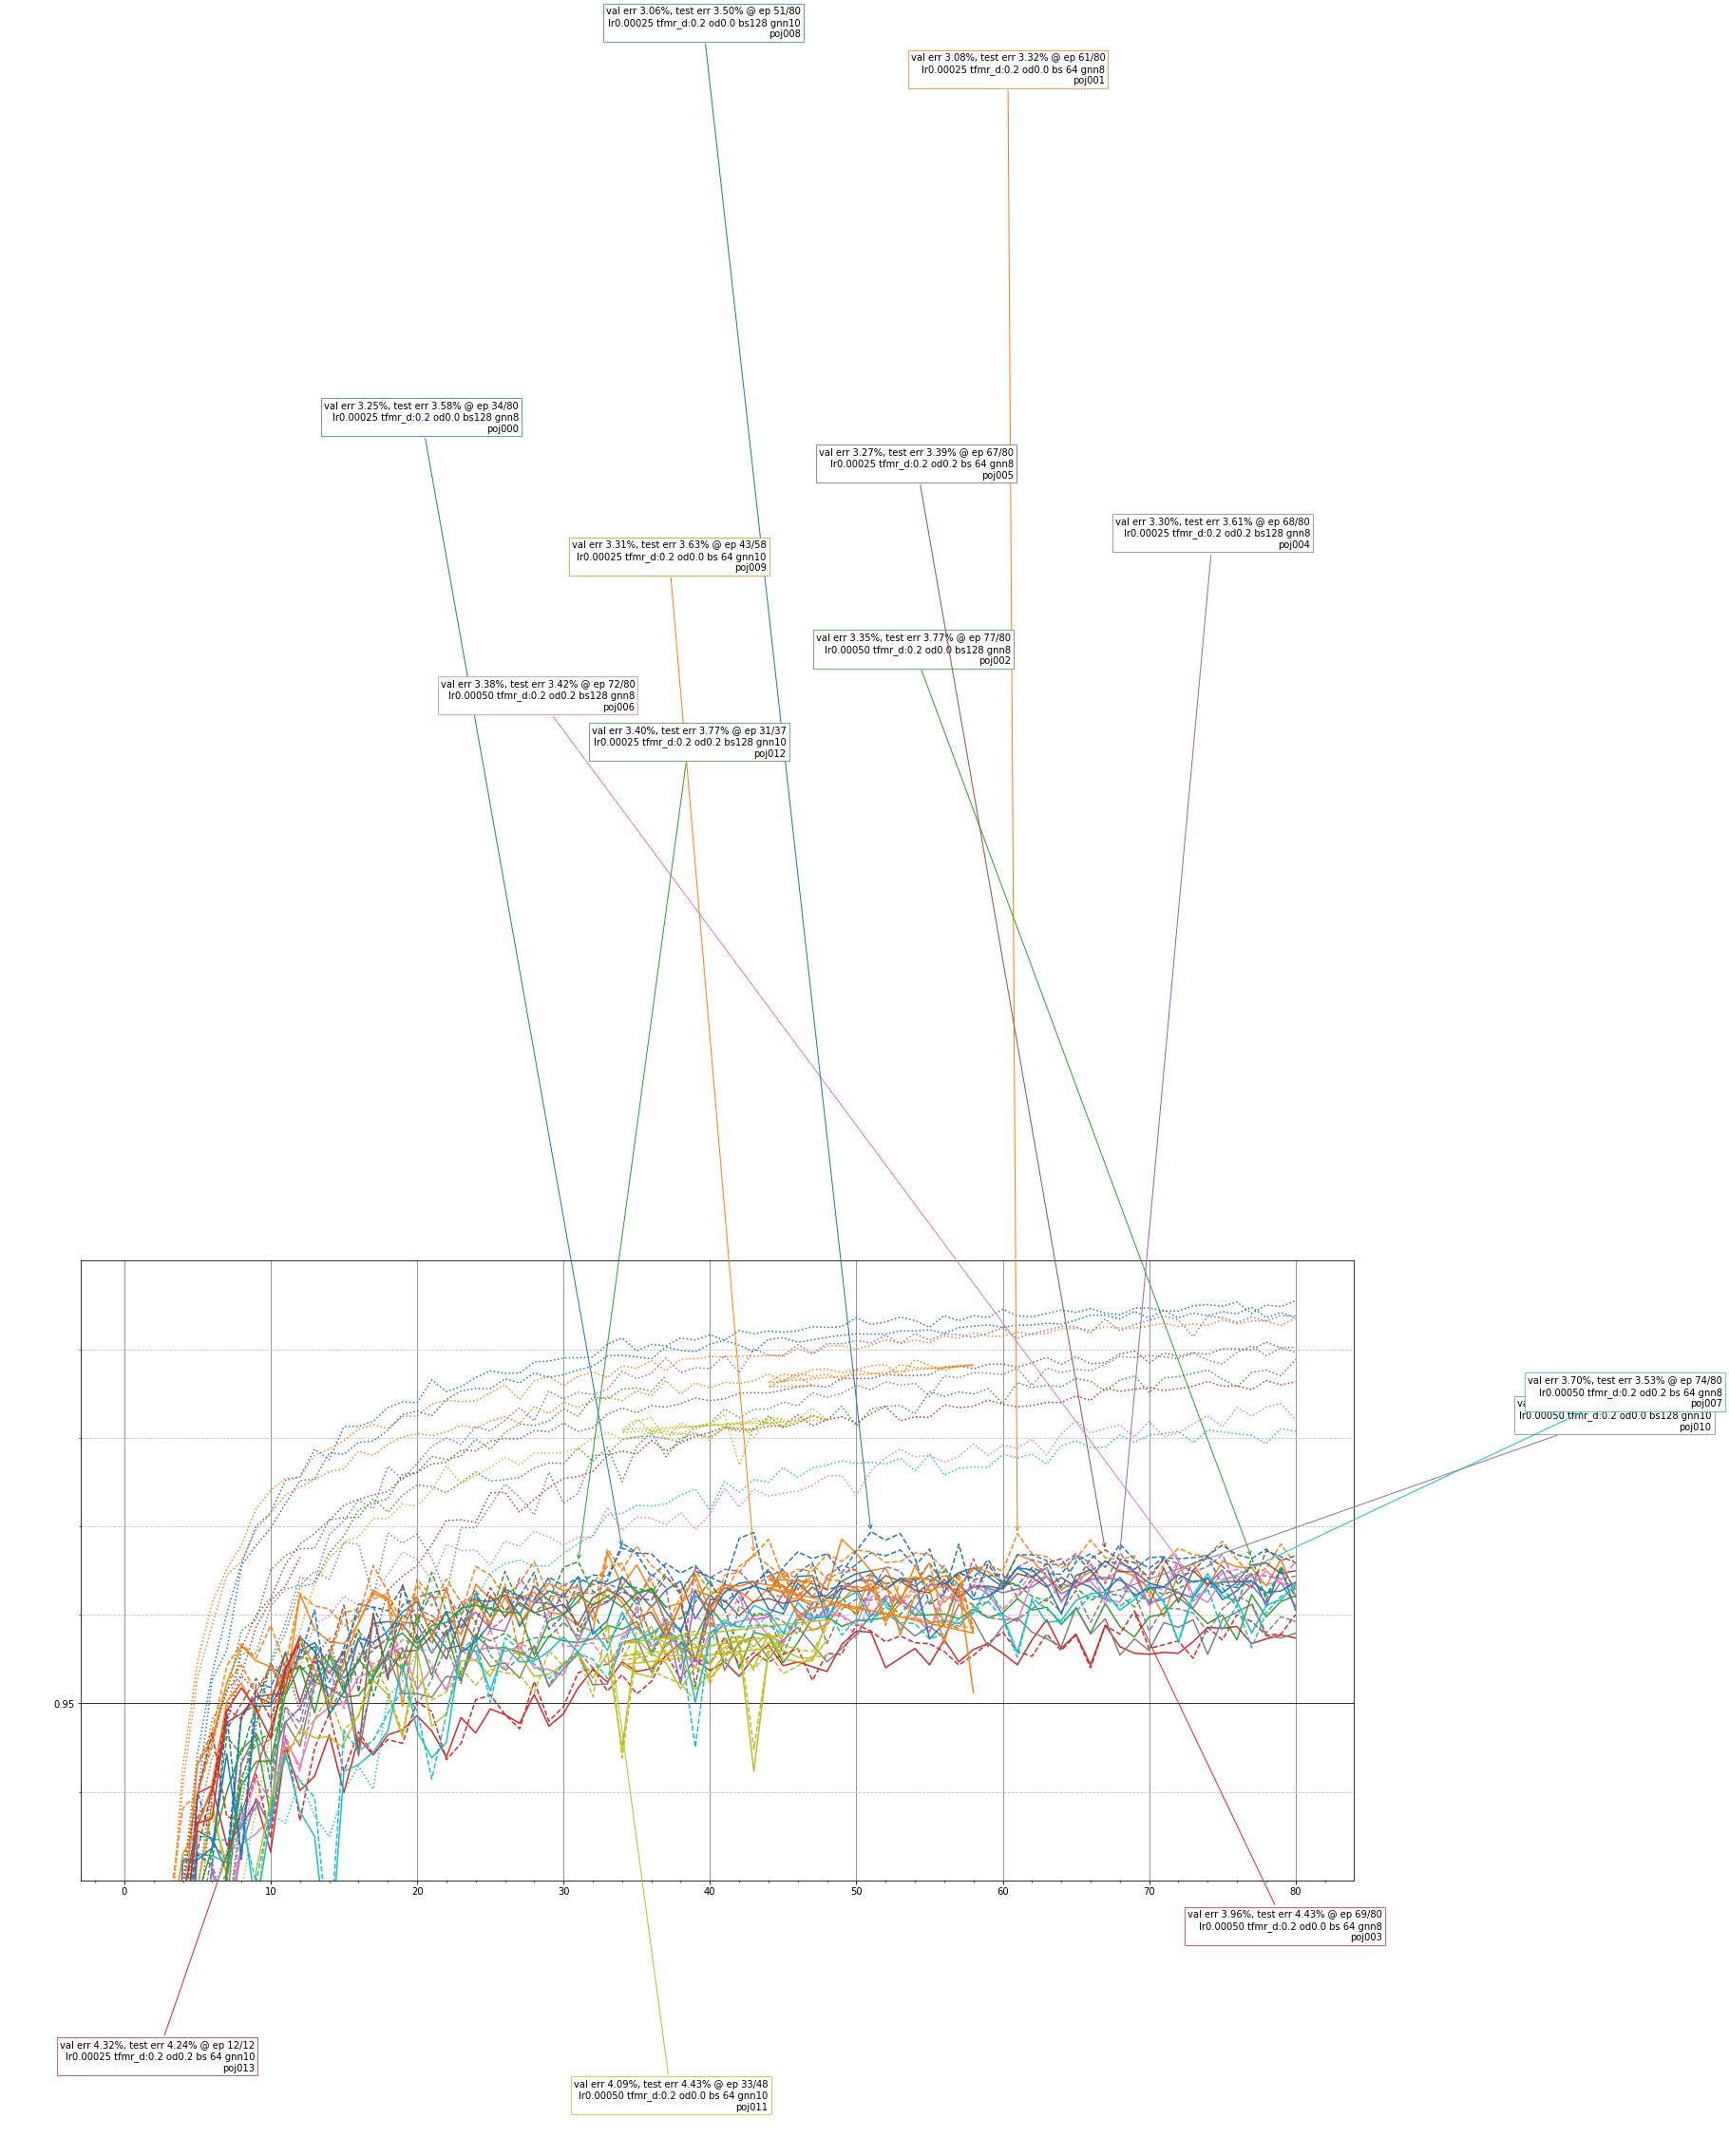

In [23]:
display_list = ['lr', 'tfmr_dropout', 'output_dropout', 'batch_size', 'gnn_layers']

plot_logs(logs, hyps, lower_ylim=0.93, display_list=display_list, legend_loc=None)